In [2]:
# import networkx as nx
# from itertools import combinations
import igraph as ig
import pandas as pd
import random
import numpy as np

##1 Read the graph

In [16]:
data = pd.read_excel('Collaboration network.xlsx', sheet_name='P1-261')

In [17]:
# Read the name of organizations
orgList = list(data['Unnamed: 0'])
len(orgList)

261

In [18]:
orgList

['ADMI-C',
 'ADNT-C',
 'ADTI-C',
 'AGIL-C',
 'AIRL-C',
 'AIRP-C',
 'ALPS-C',
 'ANMS-C',
 'APMA-C',
 'ASAH-C',
 'ASAO-C',
 'ASMI-C',
 'ASML-C',
 'ATMI-C',
 'AUOP-C',
 'AVAG-C',
 'AVEC-C',
 'AZEC-C',
 'BADI-C',
 'BOEG-C',
 'BOKH-C',
 'BOSC-C',
 'BRAX-C',
 'BRTO-C',
 'CALY-C',
 'CAMI-C',
 'CANO-C',
 'CDTC-C',
 'CENG-C',
 'CETC-C',
 'CHMO-C',
 'CHWA-C',
 'CIBA-C',
 'CKDC-C',
 'CLRN-C',
 'CNRS-C',
 'CNSJ-C',
 'COGE-C',
 'COHE-C',
 'COMS-C',
 'CORG-C',
 'CORR-C',
 'CSEM-C',
 'CYME-C',
 'CYPS-C',
 'DAIL-C',
 'DASE-C',
 'DENK-C',
 'DGBU-C',
 'DNIN-C',
 'DNIS-C',
 'DOKI-C',
 'DOSE-C',
 'DUPO-C',
 'EAST-C',
 'ELPI-C',
 'ENTG-C',
 'EPST-C',
 'ETRI-C',
 'FEIC-C',
 'FRAU-C',
 'FRSE-C',
 'FUIT-C',
 'FUJD-C',
 'FUJF-C',
 'FUKI-C',
 'FUMI-C',
 'GENE-C',
 'GEVA-C',
 'GIGA-C',
 'GLDS-C',
 'HAMM-C',
 'HERA-C',
 'HEWP-C',
 'HISC-C',
 'HITA-C',
 'HITB-C',
 'HNST-C',
 'HOND-C',
 'HONH-C',
 'HOPR-C',
 'HOYA-C',
 'HTST-C',
 'HTTE-C',
 'HUAW-C',
 'HYNX-C',
 'IBMC-C',
 'ICTI-C',
 'IDEK-C',
 'IFCN-C',
 'INFN-C',

In [238]:
# Convert the data into the adjacency matrix
adj_matrix = data.values[:,1:].astype(int)
adj_matrix = np.where(adj_matrix != 0,1,adj_matrix)
print(adj_matrix.shape)
adj_matrix

(181, 181)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [239]:
graph = ig.Graph.Adjacency(adj_matrix, mode='undirected')   # Convert the adjacency matrix to graph

In [240]:
# graph.vs['Label'] = ["N{}".format(i) for i in range(graph.vcount())]   
graph.vs['Label'] = orgList

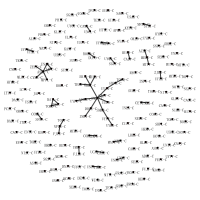

In [241]:
ig.plot(graph, bbox=(200,200), vertex_label = graph.vs['Label'], vertex_size = 1, vertex_label_size = 4, margin =10)

##2 ESU algorithm used for subgraph extraction

In [242]:
def exclusive_neighborhood(graph, v, Vp):
    assert type(graph)==ig.Graph   # graph object
    assert type(v)==int            # node, int
    assert type(Vp)==set           # node set, set  
    Nv = set(graph.neighborhood(v))        # Return all neighboring nodes of node v
    NVpll = graph.neighborhood(list(Vp))   # Return all neighboring nodes of the node set
    NVp = set([u for sublist in NVpll for u in sublist])  # Nested list deduplication. E.g., the input is [[1,2,3],[2,3],[1,4]], and the output is {1, 2, 3, 4}
    return Nv - NVp

In [243]:
def extend_subgraph(graph, Vsubgraph, Vextension, v, k, k_subgraphs):
    assert type(graph)==ig.Graph
    assert type(Vsubgraph)==set   # Vsubgraph. The subgraphs that have been constructed
    assert type(Vextension)==set  # Vextension. Set of candidate nodes for expanding subgraphs
    assert type(v)==int
    assert type(k)==int   # Subgraph size, usually set to 3 or 4
    assert type(k_subgraphs)==list
    if len(Vsubgraph) == k:
        k_subgraphs.append(Vsubgraph)
        assert 1 == len(set(graph.subgraph(Vsubgraph).connected_components(mode=ig.WEAK).membership))
        return
    while len(Vextension) > 0:
        w = random.choice(tuple(Vextension))   # Randomly take a node from the extension node set and put it into the subgraph node set
        Vextension.remove(w)
        NexclwVsubgraph = exclusive_neighborhood(graph, w, Vsubgraph)  # exclusive neighborhood
        VpExtension = Vextension | set([u for u in NexclwVsubgraph if u > v])  
        extend_subgraph(graph, Vsubgraph | set([w]), VpExtension, v, k, k_subgraphs)  # Call the extend_subgraph() function recursively
    return

In [244]:
def enumerate_subgraphs(graph, k):
    assert type(graph)==ig.Graph
    assert type(k)==int
    k_subgraphs = []
    for vertex_obj in graph.vs:
        v = vertex_obj.index
        Vextension = set([u for u in graph.neighbors(v) if u > v])
        extend_subgraph(graph, set([v]), Vextension, v, k, k_subgraphs)
    return k_subgraphs

In [245]:
three_node_subgraph = enumerate_subgraphs(graph, 3)
three_node_subgraph = [[x for x in y] for y in three_node_subgraph]  
print(len(three_node_subgraph))
three_node_subgraph[:3]

46


[[26, 179, 5], [26, 60, 5], [26, 5, 150]]

In [246]:
four_node_subgraph = enumerate_subgraphs(graph, 4)
four_node_subgraph = [[x for x in y] for y in four_node_subgraph]  
print(len(four_node_subgraph))
four_node_subgraph[:3]

93


[[179, 83, 60, 5], [26, 179, 83, 5], [179, 83, 5, 150]]

In [247]:
# Determine whether the 3-node subgraph is included in the 4-node subgraph, and obtain a new thread_dode_subgraph list
exclusive_three_node_subgraph = [a for a in three_node_subgraph if not any (set(a).issubset(set(b)) for b in four_node_subgraph)]
print(len(exclusive_three_node_subgraph))
exclusive_three_node_subgraph[:3]

3


[[80, 74, 6], [99, 27, 135], [142, 37, 94]]

##3 Determine the isomorphism of subgraphs

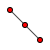

In [248]:
# Create 8 types of subgraphs
T1 = ig.Graph()
T1.add_vertices(3)
T1.add_edges([(0,1),(1,2)])
ig.plot(T1, bbox=(50,50), vertex_size = 5, margin = 10)

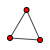

In [249]:
T2 = ig.Graph()
T2.add_vertices(3)
T2.add_edges([(0,1),(1,2),(0,2)])
ig.plot(T2, bbox=(50,50), vertex_size = 5, margin = 10)

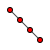

In [250]:
F1 = ig.Graph()
F1.add_vertices(4)
F1.add_edges([(0,1),(1,2),(2,3)])
ig.plot(F1, bbox=(50,50), vertex_size = 5, margin = 10)

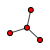

In [251]:
F2 = ig.Graph()
F2.add_vertices(4)
F2.add_edges([(0,1),(0,2),(0,3)])
ig.plot(F2, bbox=(50,50), vertex_size = 5, margin = 10)

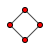

In [252]:
F3 = ig.Graph()
F3.add_vertices(4)
F3.add_edges([(0,1),(1,2),(2,3),(0,3)])
ig.plot(F3, bbox=(50,50), vertex_size = 5, margin = 10)

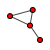

In [253]:
F4 = ig.Graph()
F4.add_vertices(4)
F4.add_edges([(0,1),(1,2),(2,3),(1,3)])
ig.plot(F4, bbox=(50,50), vertex_size = 5, margin = 10)

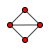

In [254]:
F5 = ig.Graph()
F5.add_vertices(4)
F5.add_edges([(0,1),(0,2),(0,3),(1,2),(2,3)])
ig.plot(F5, bbox=(50,50), vertex_size = 5, margin = 10)

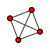

In [255]:
F6 = ig.Graph()
F6.add_vertices(4)
F6.add_edges([(0,1),(0,2),(0,3),(1,2),(1,3),(2,3)])
ig.plot(F6, bbox=(50,50), vertex_size = 5, margin = 10)

In [256]:
# Divide the extracted 3-node and 4-node subgraphs into different categories
def three_node_subgraph_classification(three_node_subgraph):
    three_node_categories = {
        'T1':[i for i in three_node_subgraph if graph.subgraph(i).isomorphic(T1)],
        'T2':[i for i in three_node_subgraph if graph.subgraph(i).isomorphic(T2)],
    }
    return three_node_categories

def four_node_subgraph_classification(four_node_subgraph):
    four_node_categories = {
        'F1':[i for i in four_node_subgraph if graph.subgraph(i).isomorphic(F1)],
        'F2':[i for i in four_node_subgraph if graph.subgraph(i).isomorphic(F2)],
        'F3':[i for i in four_node_subgraph if graph.subgraph(i).isomorphic(F3)],
        'F4':[i for i in four_node_subgraph if graph.subgraph(i).isomorphic(F4)],
        'F5':[i for i in four_node_subgraph if graph.subgraph(i).isomorphic(F5)],
        'F6':[i for i in four_node_subgraph if graph.subgraph(i).isomorphic(F6)]
    }
    return four_node_categories

In [257]:
three_node_dict = three_node_subgraph_classification(three_node_subgraph)
four_node_dict = four_node_subgraph_classification(four_node_subgraph)
exclusive_three_node_dict = three_node_subgraph_classification(exclusive_three_node_subgraph)

In [264]:
subgraph_count_3 = {}
node_in_subgraph_3 = {}
for key, value in three_node_dict.items():
# for key, value in exclusive_three_node_dict.items():
    number_of_subgraph = len(value)
    subgraph_count_3[key] = number_of_subgraph

    node_counts = {}
    for sublist in value:
        for item in sublist:
            node_counts[item] = node_counts.get(item, 0) + 1
        node_in_subgraph_3[key] = node_counts

print(subgraph_count_3)
print(node_in_subgraph_3)

{'T1': 2, 'T2': 1}
{'T1': {80: 1, 74: 1, 6: 1, 142: 1, 37: 1, 94: 1}, 'T2': {99: 1, 27: 1, 135: 1}}


In [265]:
data = pd.DataFrame(node_in_subgraph_3)
data.to_excel('1.xlsx', index=True)

In [266]:
subgraph_count_4 = {}
node_in_subgraph_4 = {}
for key, value in four_node_dict.items():
    number_of_subgraph = len(value)
    subgraph_count_4[key] = number_of_subgraph

    node_counts = {}
    for sublist in value:
        for item in sublist:
            node_counts[item] = node_counts.get(item, 0) + 1
        node_in_subgraph_4[key] = node_counts

print(subgraph_count_4)
print(node_in_subgraph_4)

{'F1': 44, 'F2': 46, 'F3': 0, 'F4': 3, 'F5': 0, 'F6': 0}
{'F1': {121: 13, 122: 44, 171: 7, 12: 7, 85: 6, 52: 22, 130: 6, 118: 6, 160: 12, 170: 6, 51: 7, 165: 13, 32: 12, 55: 6, 157: 7, 137: 1, 167: 1}, 'F2': {179: 5, 83: 5, 60: 3, 5: 7, 26: 5, 150: 3, 160: 15, 121: 15, 122: 38, 12: 15, 157: 15, 165: 15, 52: 19, 32: 15, 130: 3, 85: 3, 118: 3}, 'F4': {83: 1, 60: 3, 5: 3, 150: 3, 179: 1, 26: 1}}


In [267]:
data = pd.DataFrame(node_in_subgraph_4)
data.to_excel('1.xlsx', index=True)